In [1]:
# importing the Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras_tuner import Hyperband
import tensorflow as tf

In [3]:
# load the predictive maintenance dataset
Pred_main_data = pd.read_csv('ai4i2020.csv')
Pred_main_data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [4]:
# Remove the 'UDI' and 'Product ID' columns
Pred_main_data = Pred_main_data.drop(columns=['UDI', 'Product ID'])

In [5]:
# Encode the 'type' column categorical variables(low, mediam, high quality)
Pred_main_data['Type'] = Pred_main_data['Type'].map({'L': 0, 'M': 1, 'H': 2})

In [6]:
# statistics of the dataset
Pred_main_data.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.500300,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,0.671301,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,2.000000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [7]:
# Checking the missing values
print(Pred_main_data.isnull().sum())

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [8]:
# Check the data types of each column
print(Pred_main_data.dtypes)

Type                         int64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


In [9]:
# print the count of target variables
Pred_main_data['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

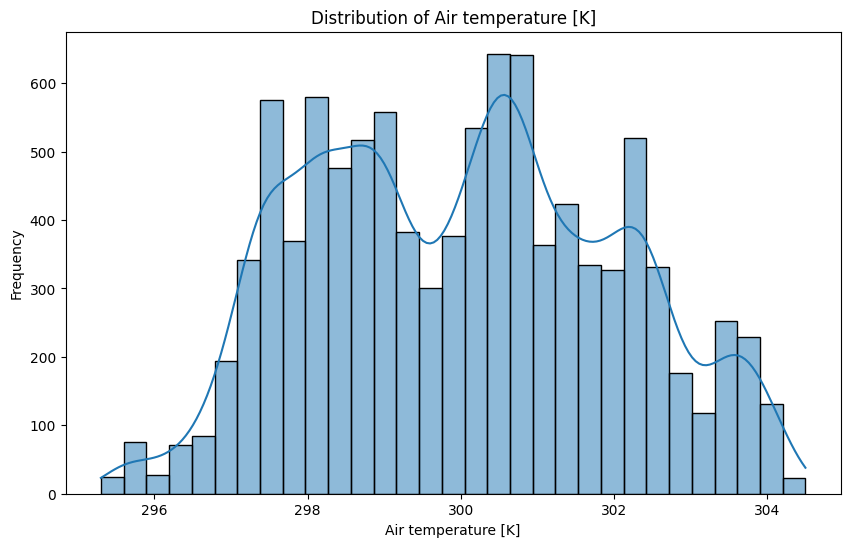

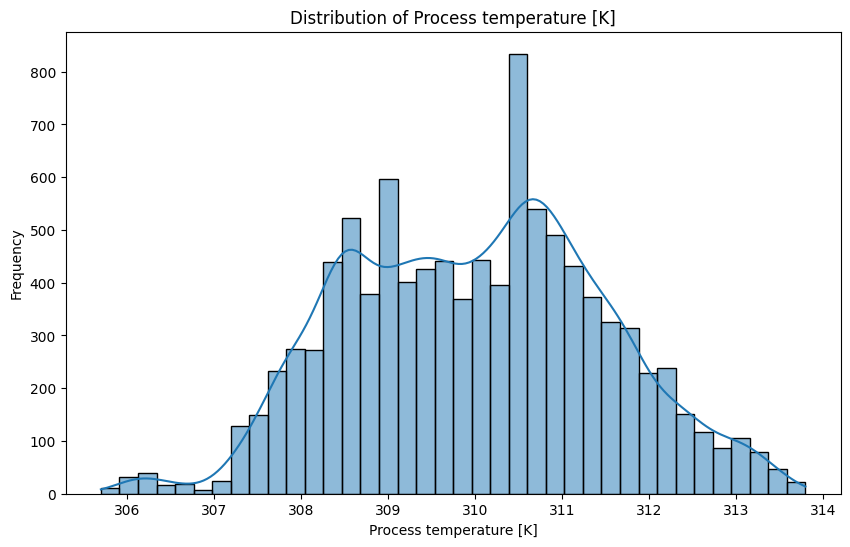

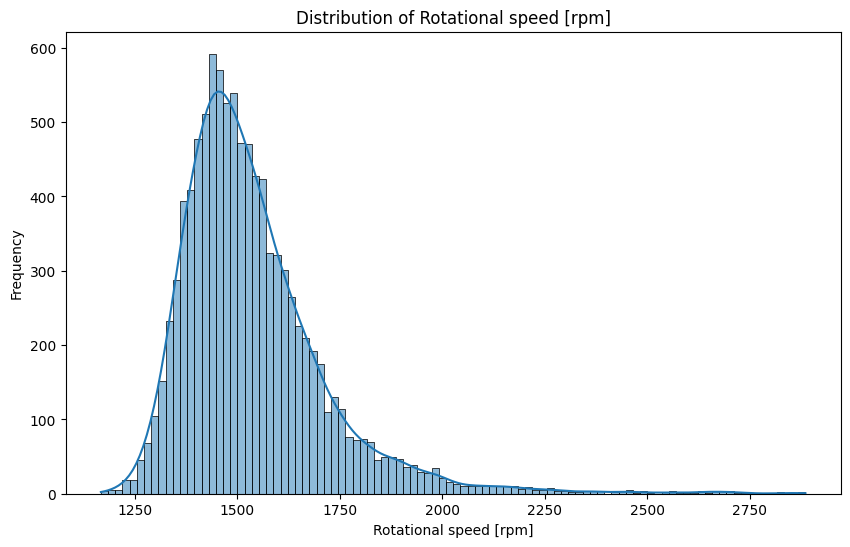

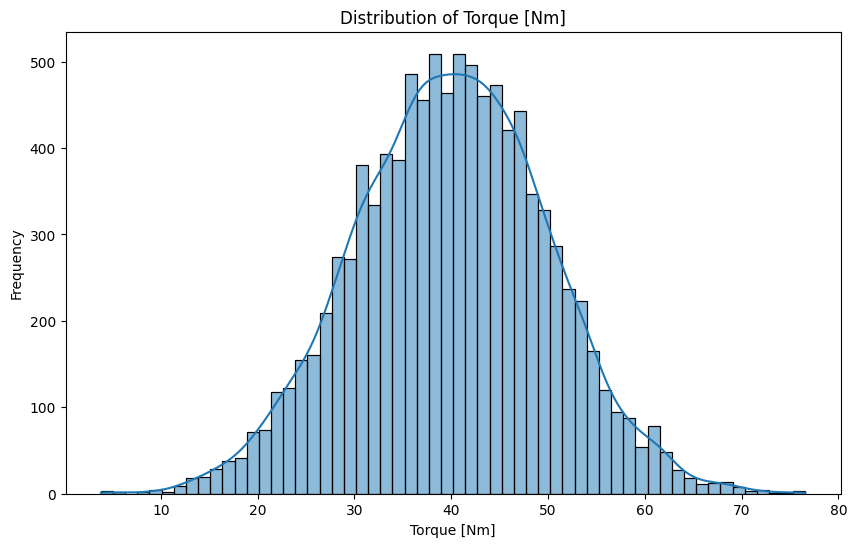

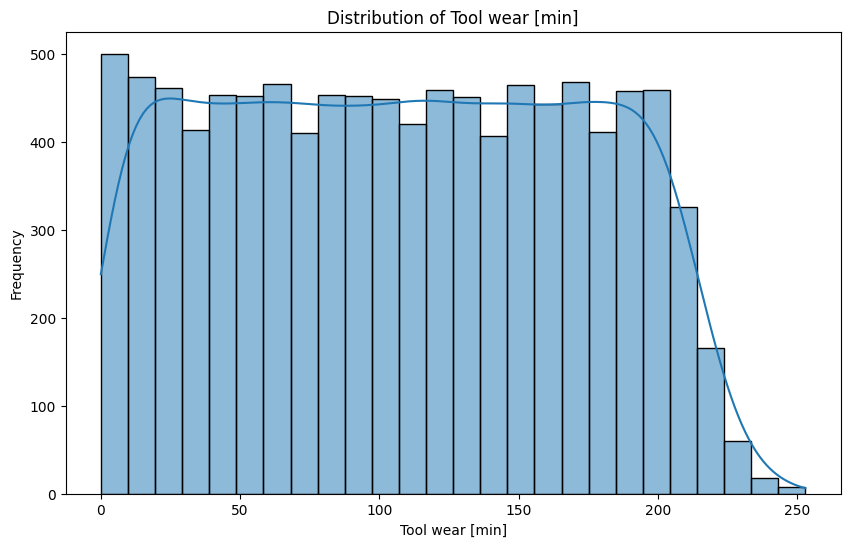

In [10]:
# List of numerical features
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Plot histograms for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(Pred_main_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

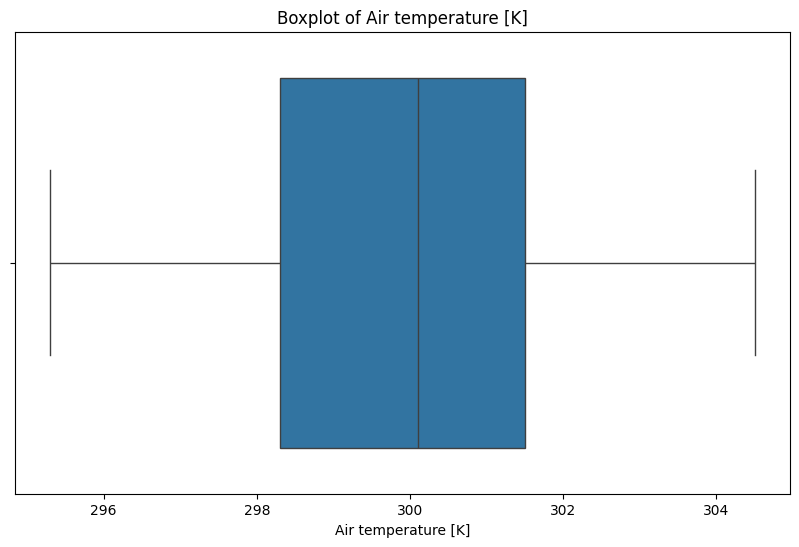

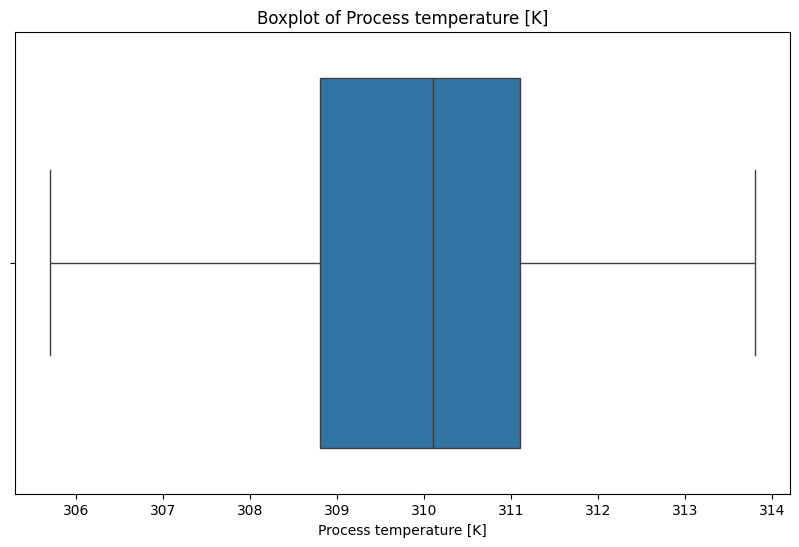

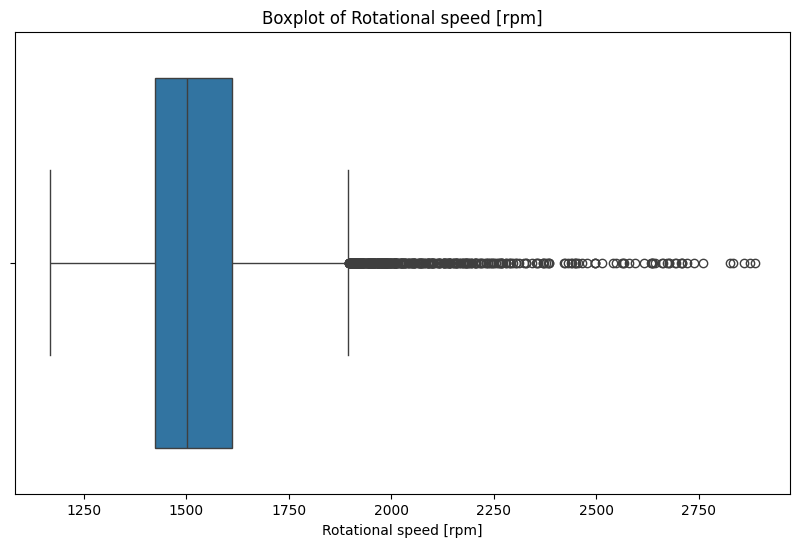

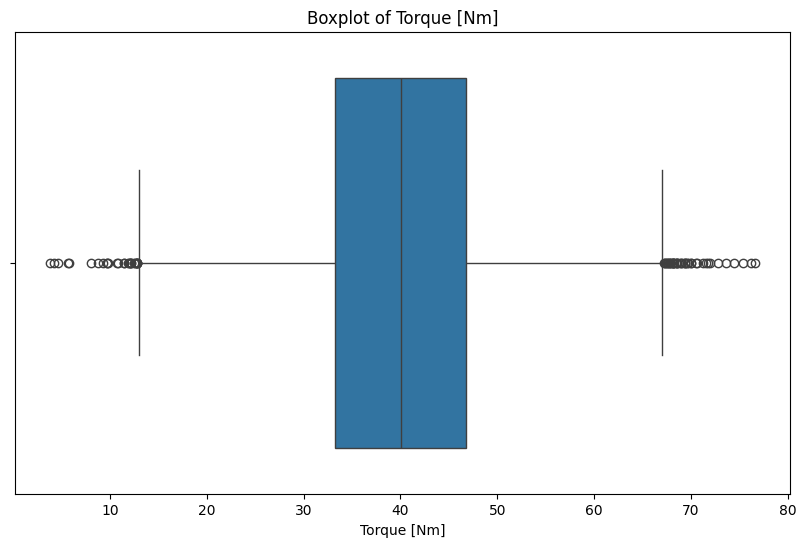

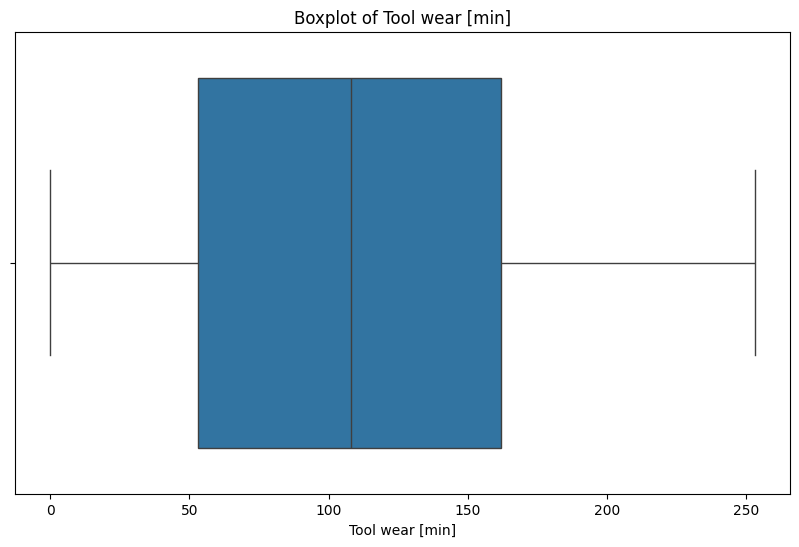

In [11]:
# Plot box plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=Pred_main_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.show()

In [12]:
# Define a function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from 'Rotational speed [rpm]' and 'Torque [Nm]'
df = remove_outliers(Pred_main_data, 'Rotational speed [rpm]')
df = remove_outliers(Pred_main_data, 'Torque [Nm]')

# Verify the result
print("Dataset shape after removing outliers:", df.shape)

Dataset shape after removing outliers: (9931, 12)


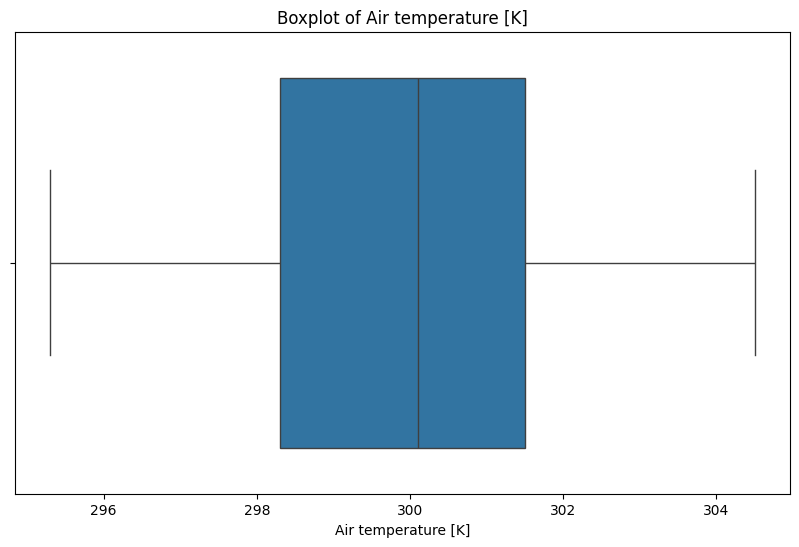

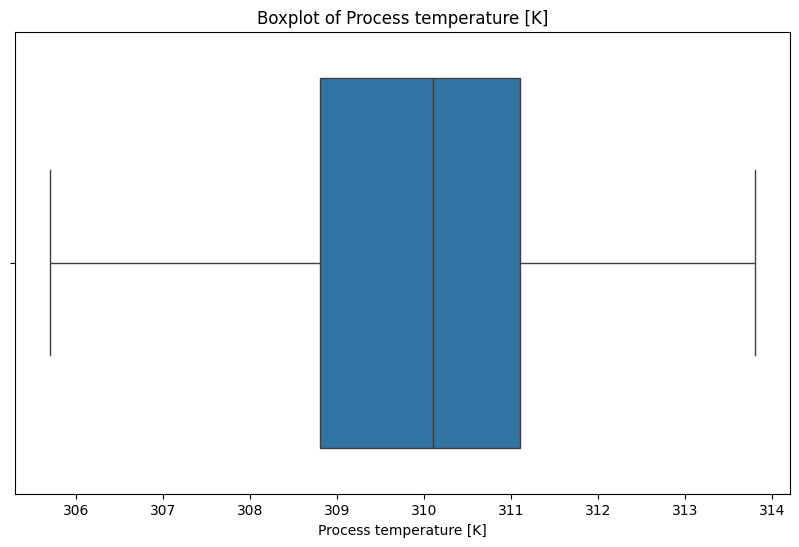

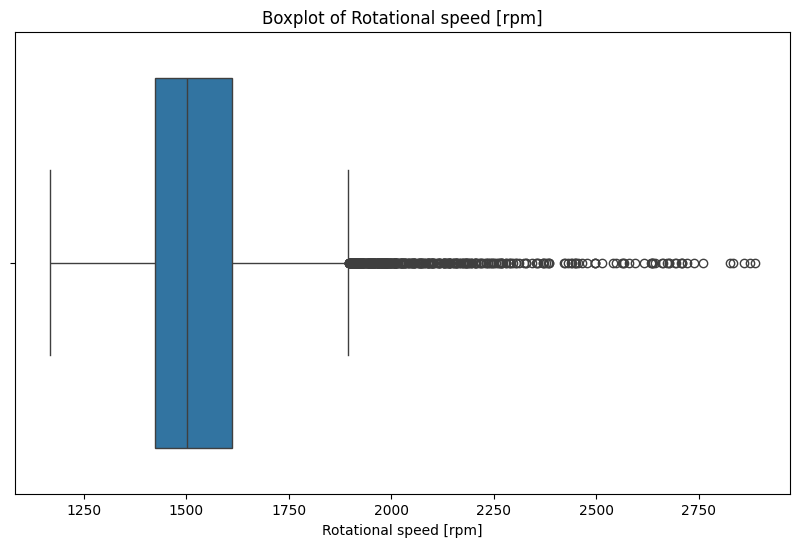

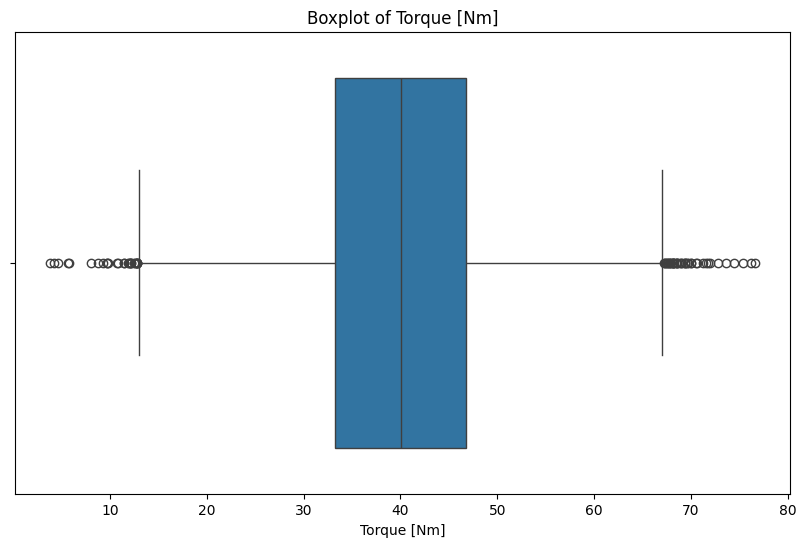

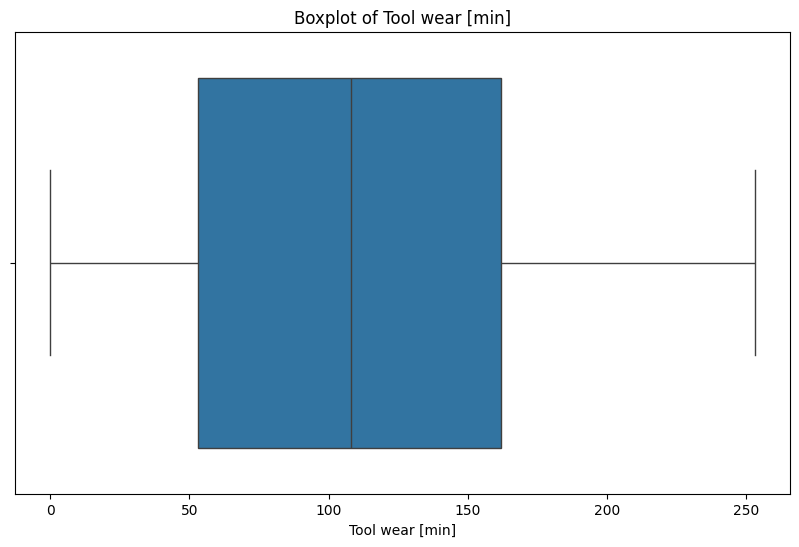

In [13]:
# Plot box plots for numerical features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=Pred_main_data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.show()

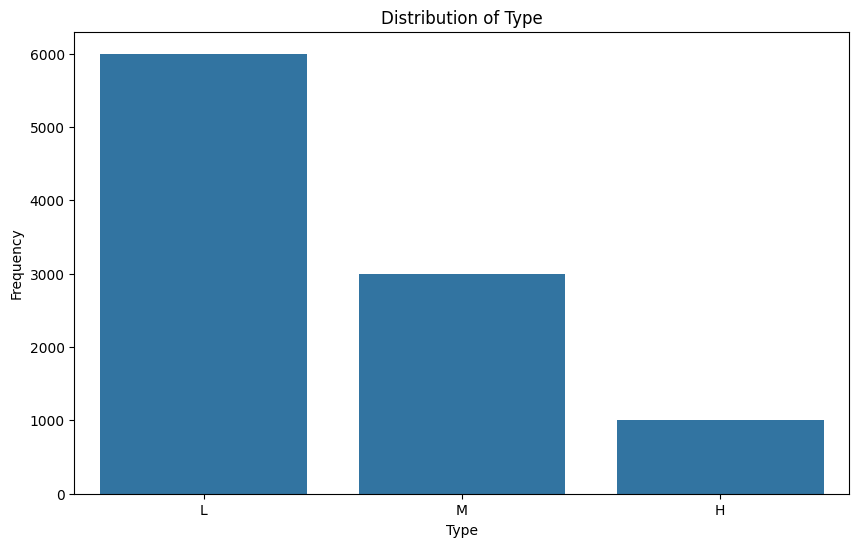

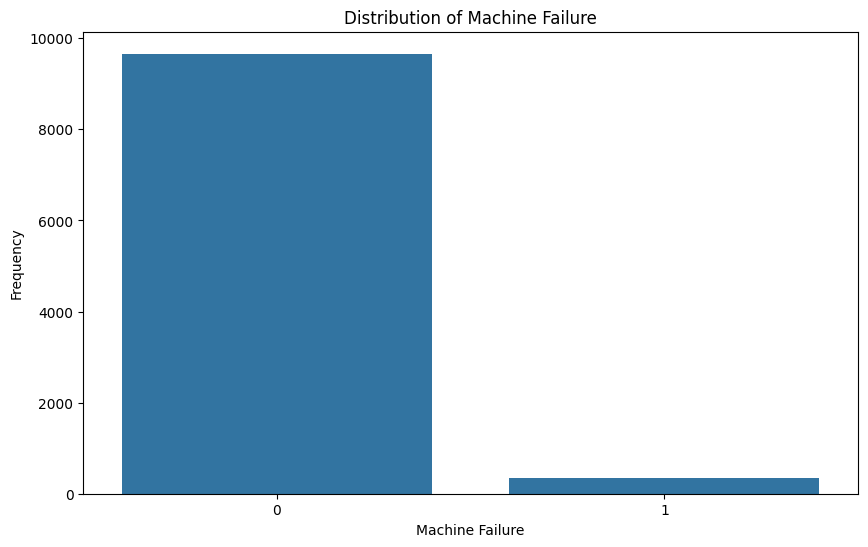

In [14]:
# Plot count plot for the 'Type' feature
plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=Pred_main_data)
plt.title('Distribution of Type')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['L', 'M', 'H'])
plt.show()

# Plot count plot for the 'Machine failure' feature
plt.figure(figsize=(10, 6))
sns.countplot(x='Machine failure', data=Pred_main_data)
plt.title('Distribution of Machine Failure')
plt.xlabel('Machine Failure')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Separate features and target
X = Pred_main_data.drop(columns=['Machine failure'])
y = Pred_main_data['Machine failure']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Combine the resampled features and target into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['Machine failure'])], axis=1) 

In [16]:
df_resampled['Machine failure'].value_counts()

Machine failure
0    9661
1    9661
Name: count, dtype: int64

In [17]:
df_resampled.shape

(19322, 12)

In [18]:
# Select numerical columns to normalize (excluding 'Machine failure' if it's your target variable)
numerical_cols = df_resampled.drop(columns=['Machine failure']).columns

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df_resampled[numerical_cols] = scaler.fit_transform(df_resampled[numerical_cols])

# Display the first few rows to check the normalized data
df_resampled.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Machine failure
0,0.5,0.304348,0.358025,0.222934,0.535714,0.000000,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.315217,0.370370,0.139697,0.583791,0.011858,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.304348,0.345679,0.192084,0.626374,0.019763,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.315217,0.358025,0.154249,0.490385,0.027668,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.315217,0.370370,0.139697,0.497253,0.035573,0.0,0.0,0.0,0.0,0.0,0


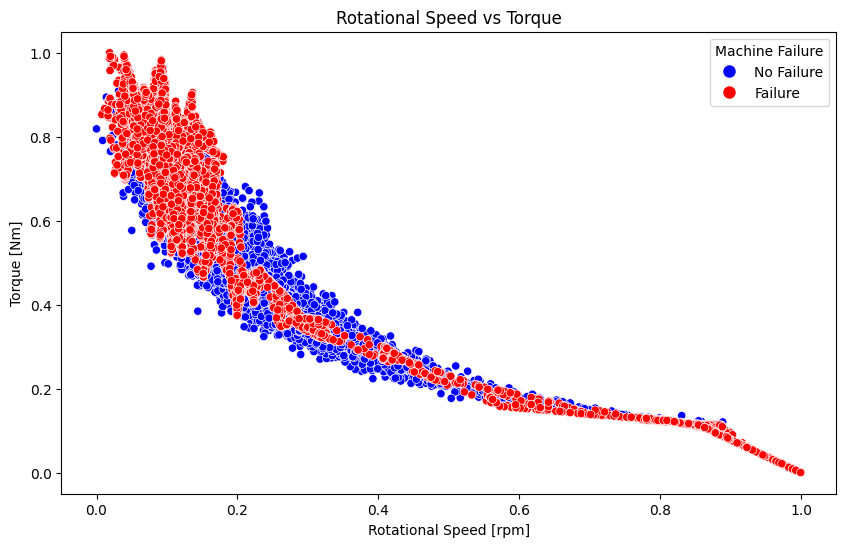

In [19]:
# Define colors for 'Failure' (red) and 'No Failure' (blue)
failure_colors = {0: 'blue', 1: 'red'}

plt.figure(figsize=(10, 6))
# Plot scatter plot with specific colors
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]', hue='Machine failure', data=df_resampled,
                palette=failure_colors)

plt.title('Rotational Speed vs Torque')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Torque [Nm]')

# Create custom legend
legend_labels = ['No Failure', 'Failure']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in failure_colors.values()]
plt.legend(legend_handles, legend_labels, title='Machine Failure')

plt.show()

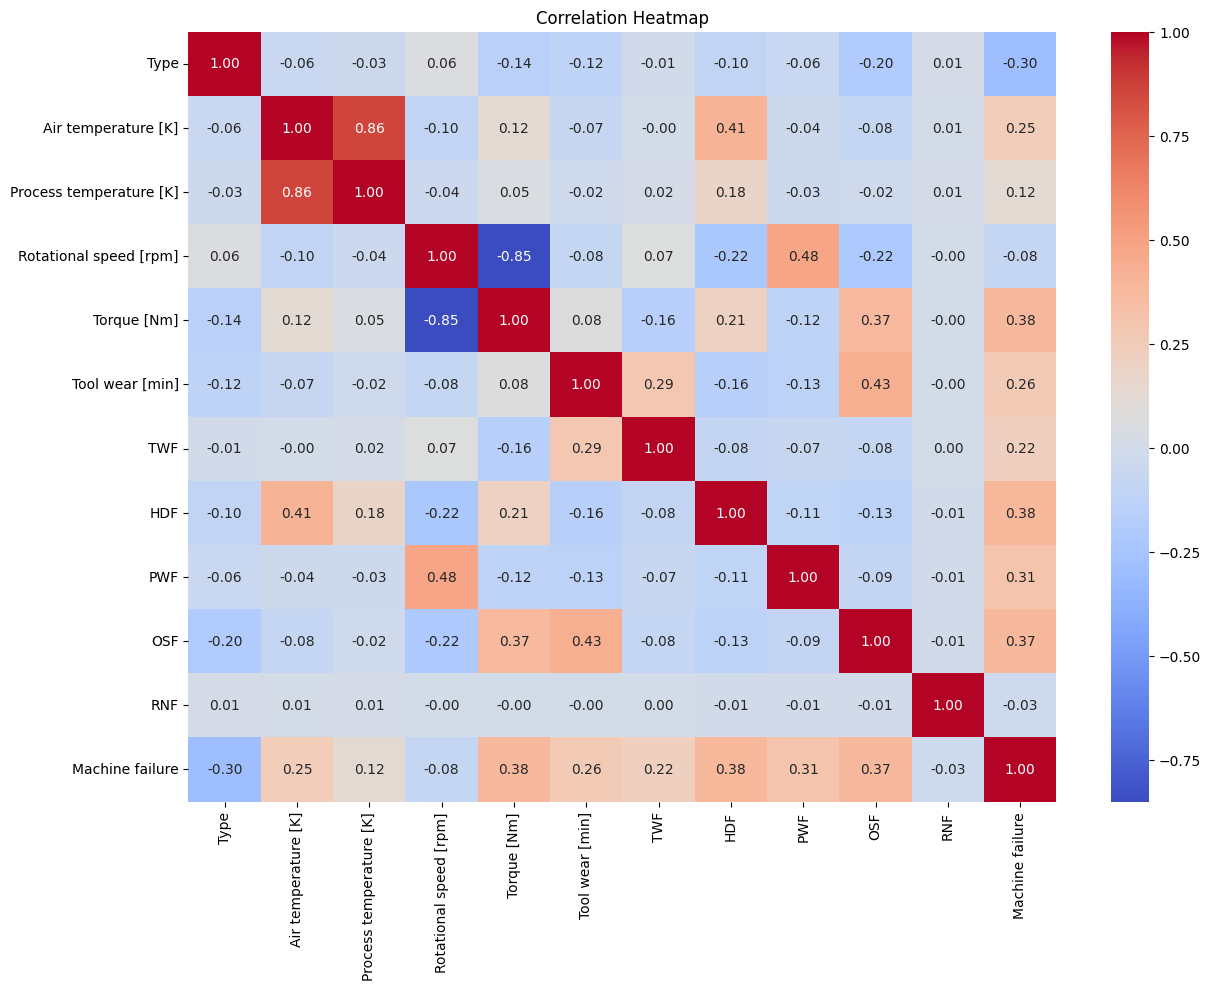

In [20]:
# Calculate the correlation matrix
correlation_matrix = df_resampled.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [21]:
X = df_resampled.drop(columns=['Machine failure'])
y = df_resampled['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Printing the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15457, 11)
X_test shape: (3865, 11)
y_train shape: (15457,)
y_test shape: (3865,)


Random Forest

In [23]:
Prmain_rf = RandomForestClassifier(random_state=42)

Prmain_rf.fit(X_train, y_train)

y_pred_Prmain_rf = Prmain_rf.predict(X_test)

In [24]:
def evaluate_predictive_maintenance_model(y_true, y_pred):
    """
    Prints the classification report and visualizes the confusion matrix.

    Parameters:
    - y_true: Ground truth target values.
    - y_pred: Estimated targets as returned by a classifier.
    - class_names: List of class names for labeling the confusion matrix.

    Returns:
    - None
    """
    class_names = ['No Failure', 'Failure']

    # Print classification report
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.98      0.99      0.99      1934
     Failure       0.99      0.98      0.99      1931

    accuracy                           0.99      3865
   macro avg       0.99      0.99      0.99      3865
weighted avg       0.99      0.99      0.99      3865



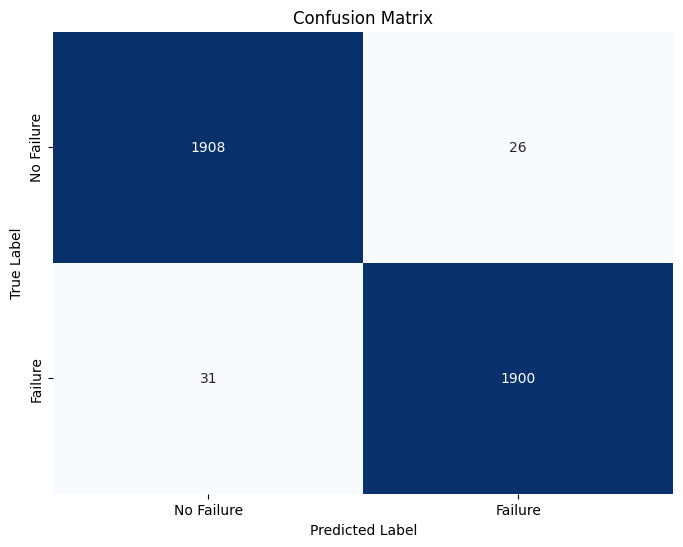

In [25]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_rf)

Gradient Boosting

In [26]:
Prmain_gb = GradientBoostingClassifier(random_state=42)

# Fit the model on the training data
Prmain_gb.fit(X_train, y_train)

# Predict on the test data
y_pred_Prmain_rf = Prmain_gb.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.95      0.97      0.96      1934
     Failure       0.97      0.95      0.96      1931

    accuracy                           0.96      3865
   macro avg       0.96      0.96      0.96      3865
weighted avg       0.96      0.96      0.96      3865



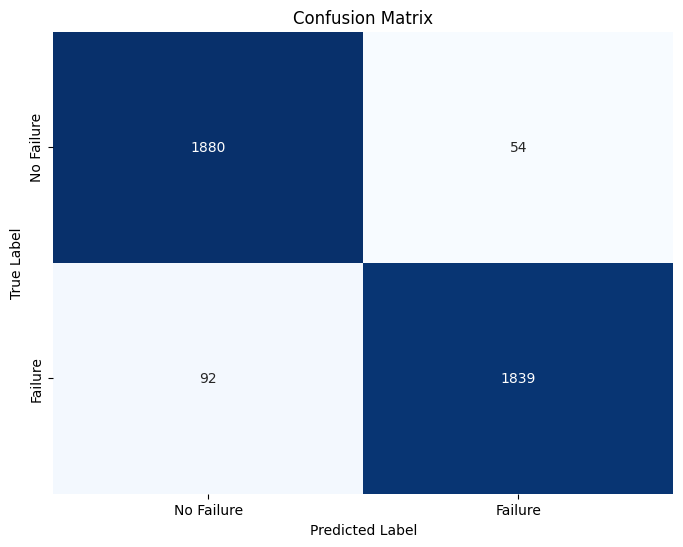

In [27]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_rf)

SVM

In [28]:
Prmain_svc = SVC(random_state=42)

Prmain_svc.fit(X_train, y_train)

y_pred_Prmain_svc = Prmain_svc.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.94      0.96      0.95      1934
     Failure       0.96      0.93      0.95      1931

    accuracy                           0.95      3865
   macro avg       0.95      0.95      0.95      3865
weighted avg       0.95      0.95      0.95      3865



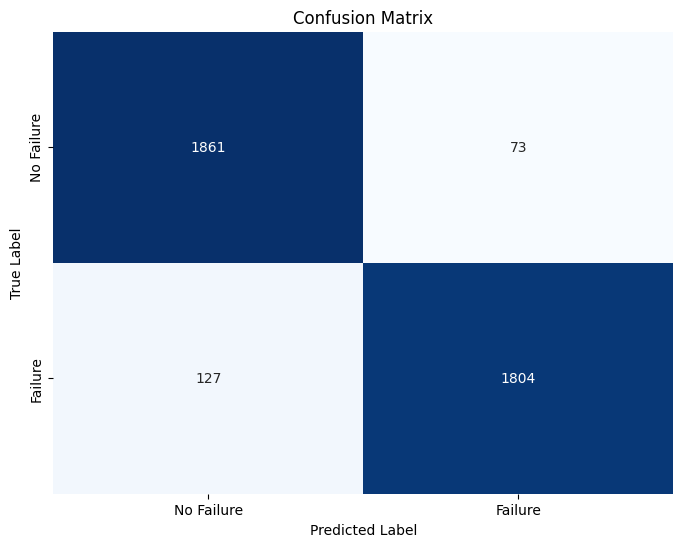

In [29]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_svc)

KNN

In [30]:
Prmain_knn = KNeighborsClassifier()

Prmain_knn.fit(X_train, y_train)

y_pred_Prmain_knn = Prmain_knn.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.96      0.97      1934
     Failure       0.96      0.99      0.97      1931

    accuracy                           0.97      3865
   macro avg       0.97      0.97      0.97      3865
weighted avg       0.97      0.97      0.97      3865



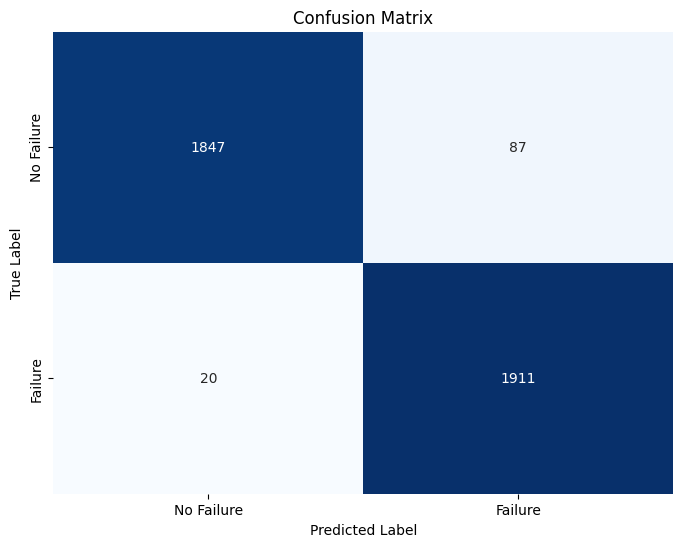

In [31]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_knn)

ANN

In [32]:
# Initialize the ANN model
Prmain_ann = Sequential()
Prmain_ann.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
Prmain_ann.add(Dense(32, activation='relu'))  # Hidden layer
Prmain_ann.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
Prmain_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
    patience=10,
    restore_best_weights=True)

# Fit the model on the training data
history = Prmain_ann.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8115 - loss: 0.4202 - val_accuracy: 0.9149 - val_loss: 0.2008
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9359 - loss: 0.1740 - val_accuracy: 0.9256 - val_loss: 0.1687
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9405 - loss: 0.1488 - val_accuracy: 0.9415 - val_loss: 0.1436
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9501 - loss: 0.1338 - val_accuracy: 0.9411 - val_loss: 0.1410
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9456 - loss: 0.1396 - val_accuracy: 0.9408 - val_loss: 0.1394
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9413 - loss: 0.1431 - val_accuracy: 0.9382 - val_loss: 0.1465
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9490 - loss: 0.1253 - val_accuracy: 0.9447 - val_loss: 0.1350
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9463 - loss: 0.1306 - val_accu

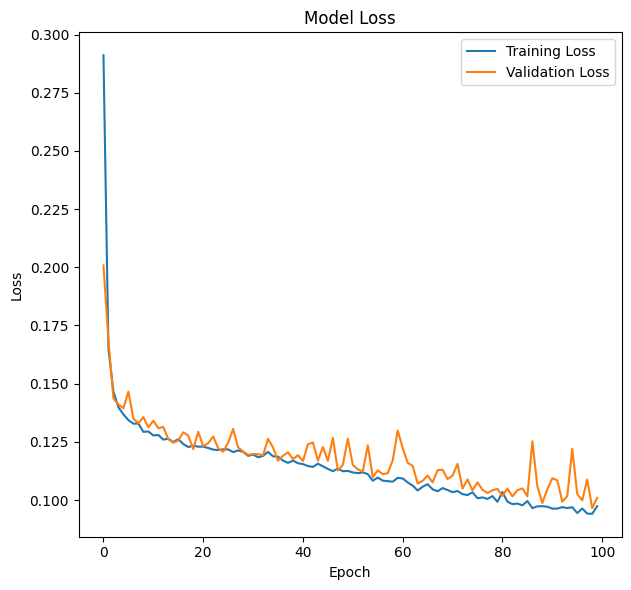

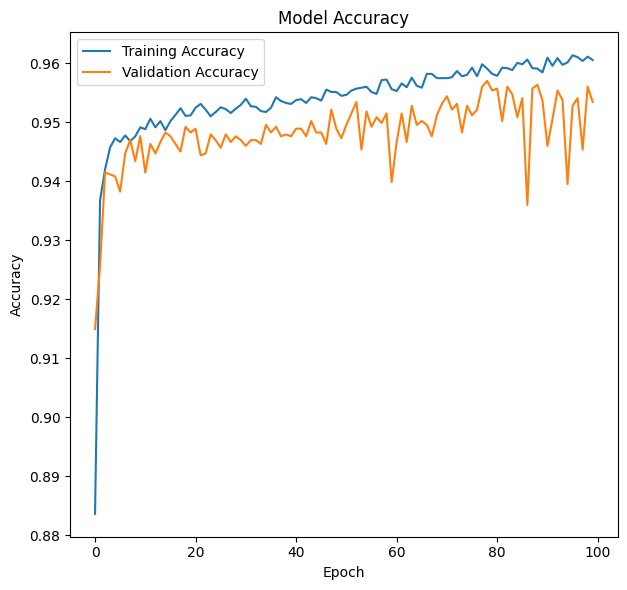

In [33]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Classification Report:
              precision    recall  f1-score   support

  No Failure       0.50      1.00      0.67      1934
     Failure       0.00      0.00      0.00      1931

    accuracy                           0.50      3865
   macro avg       0.25      0.50      0.33      3865
weighted avg       0.25      0.50      0.33      3865



C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

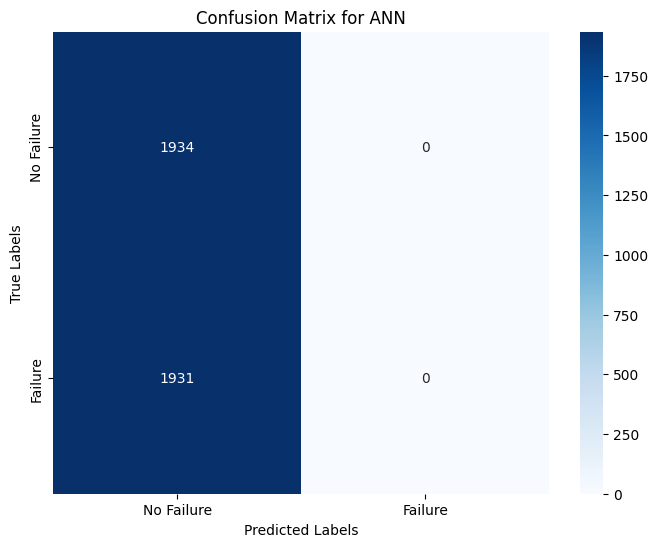

In [34]:
# Predict on the test set
y_pred_prob_Prmain_ann = Prmain_ann.predict(X_test)
y_pred_Prmain_ann = y_pred_prob_Prmain_ann.argmax(axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_Prmain_ann, target_names=['No Failure', 'Failure']))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_Prmain_ann)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ANN')
plt.show()

Hyperparametertuning

Random Forest

In [35]:
# Define the parameter grid
rf_param_grid = {
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}


Prmain_rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=Prmain_rf, param_grid=rf_param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Best Random Forest model
Prmain_best_rf = grid_search.best_estimator_

# Make predictions
y_pred_Prmain_rf_hy = Prmain_best_rf.predict(X_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.99      0.99      1934
     Failure       0.99      0.99      0.99      1931

    accuracy                           0.99      3865
   macro avg       0.99      0.99      0.99      3865
weighted avg       0.99      0.99      0.99      3865



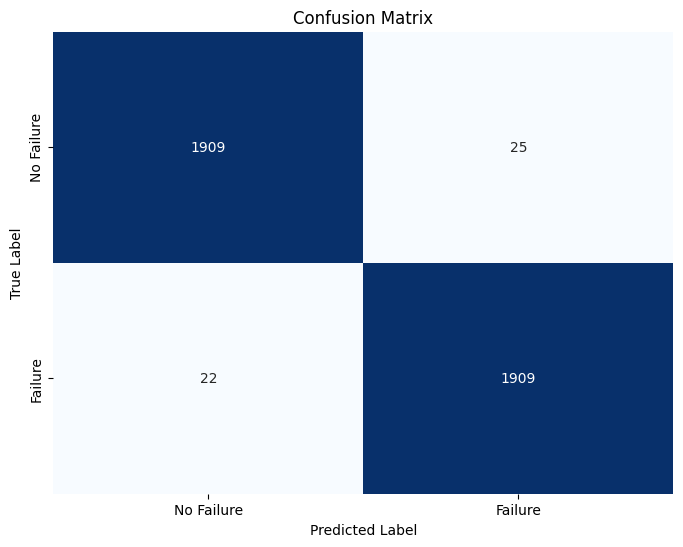

In [36]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_rf_hy)

Gradient Boosting

In [37]:
gb_param_grid = {
    'n_estimators': [100, 200],          # Number of boosting stages to be run
    'min_samples_split': [2, 5],          # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2],            # Minimum number of samples required at each leaf node
    'subsample': [0.8, 0.9],              # Fraction of samples used for fitting the individual base learners
     'learning_rate': [0.01, 0.1],        # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4]                  # Maximum depth of the individual estimators
}

# Initialize a GradientBoostingClassifier
Prmain_gb = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=Prmain_gb, param_grid=gb_param_grid,
                              cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_gb.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params_gb = grid_search_gb.best_params_
print(f"Best hyperparameters: {best_params_gb}")

# Best Gradient Boosting model
Prmain_best_gb = grid_search_gb.best_estimator_

# Make predictions
y_pred_Prmain_gb_hy = Prmain_best_gb.predict(X_test)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.9}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.98      0.99      0.98      1934
     Failure       0.99      0.98      0.98      1931

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865



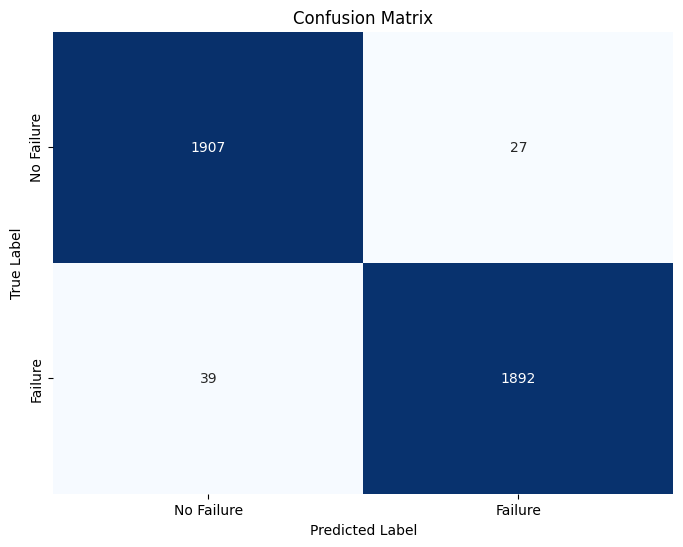

In [38]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_gb_hy)

SVM

In [39]:
# Define the parameter grid
svm_param_grid = {
    'C': [0.1, 1],           # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'kernel': ['rbf', 'linear', 'sigmoid']  # Specifies the kernel type to be used in the algorithm
}

# Initialize an SVC (Support Vector Classifier)
Prmain_svc = SVC()

# Initialize GridSearchCV
grid_search_svc = GridSearchCV(estimator=Prmain_svc, param_grid=svm_param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_svc.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params_svc = grid_search_svc.best_params_
print(f"Best hyperparameters: {best_params_svc}")

# Best SVM model
Prmain_best_svc = grid_search_svc.best_estimator_

# Make predictions
y_pred_Prmain_svc_hy = Prmain_best_svc.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.94      0.96      0.95      1934
     Failure       0.96      0.93      0.95      1931

    accuracy                           0.95      3865
   macro avg       0.95      0.95      0.95      3865
weighted avg       0.95      0.95      0.95      3865



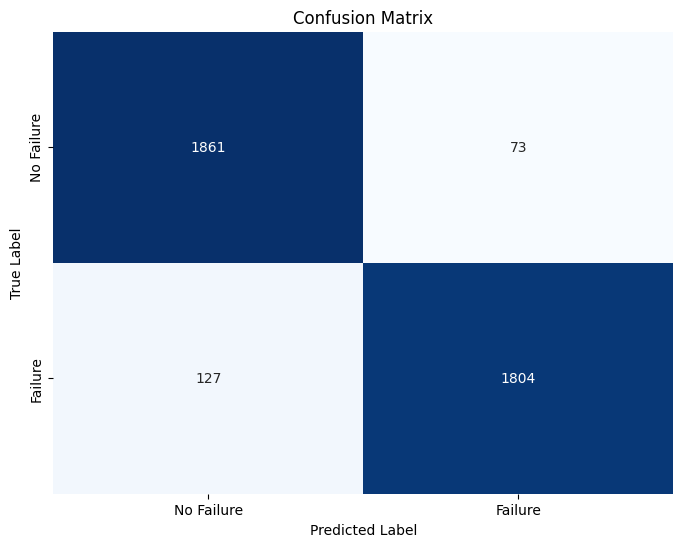

In [40]:
evaluate_predictive_maintenance_model(y_test, y_pred_Prmain_svc_hy)

KNN

In [41]:
# Define the parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Initialize a KNeighborsClassifier
Prmain_knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=Prmain_knn, param_grid=knn_param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_knn.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params_knn = grid_search_knn.best_params_
print(f"Best hyperparameters: {best_params_knn}")

# Best KNN model
best_knn = grid_search_knn.best_estimator_

# Make predictions
y_pred_knn_Prmain_hy = best_knn.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.96      0.98      1934
     Failure       0.96      0.99      0.98      1931

    accuracy                           0.98      3865
   macro avg       0.98      0.98      0.98      3865
weighted avg       0.98      0.98      0.98      3865



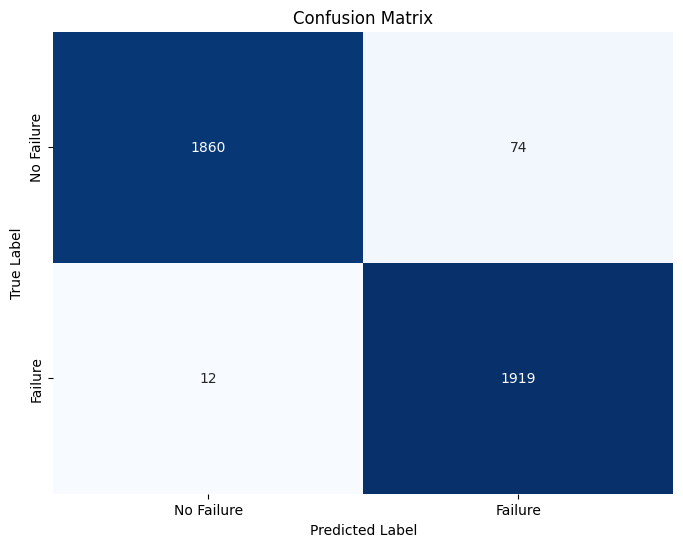

In [42]:
evaluate_predictive_maintenance_model(y_test, y_pred_knn_Prmain_hy)

ANN

In [43]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [44]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=1,
    directory='project_dir',
    project_name='ann_hyperparameter_tuning'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 15s]
val_accuracy: 0.9375808835029602

Best val_accuracy So Far: 0.9511643052101135
Total elapsed time: 00h 03m 20s


In [45]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Number of units in first Dense layer: {best_hyperparameters.get('units1')}")
print(f"Number of units in second Dense layer: {best_hyperparameters.get('units2')}")
print(f"Learning rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
Number of units in first Dense layer: 128
Number of units in second Dense layer: 48
Learning rate: 0.002039939361228674


In [46]:
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Epoch 1/50


C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9461 - loss: 0.1307 - val_accuracy: 0.9424 - val_loss: 0.1341
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9447 - loss: 0.1283 - val_accuracy: 0.9444 - val_loss: 0.1324
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9515 - loss: 0.1162 - val_accuracy: 0.9473 - val_loss: 0.1274
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9511 - loss: 0.1164 - val_accuracy: 0.9479 - val_loss: 0.1158
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9459 - loss: 0.1257 - val_accuracy: 0.9463 - val_loss: 0.1231
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9538 - loss: 0.1139 - val_accuracy: 0.9447 - val_loss: 0.1315
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9502 - loss: 0.1192 - val_accuracy: 0.9486 - val_loss: 0.1113
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9526 - loss: 0.1164 - val_accuracy: 0.9499 - val_

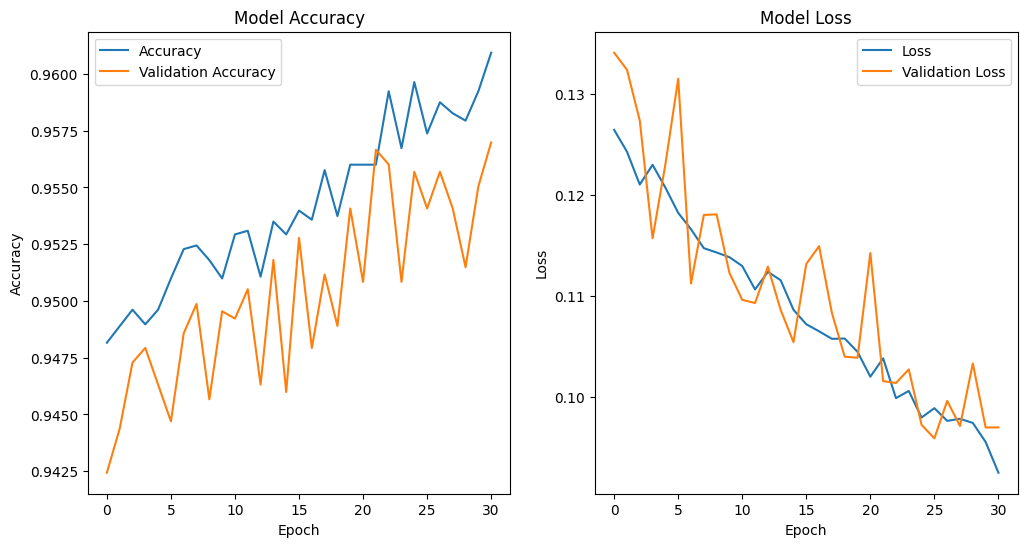

In [47]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
Classification Report:
              precision    recall  f1-score   support

  No Failure       0.50      1.00      0.67      1934
     Failure       0.00      0.00      0.00      1931

    accuracy                           0.50      3865
   macro avg       0.25      0.50      0.33      3865
weighted avg       0.25      0.50      0.33      3865



C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

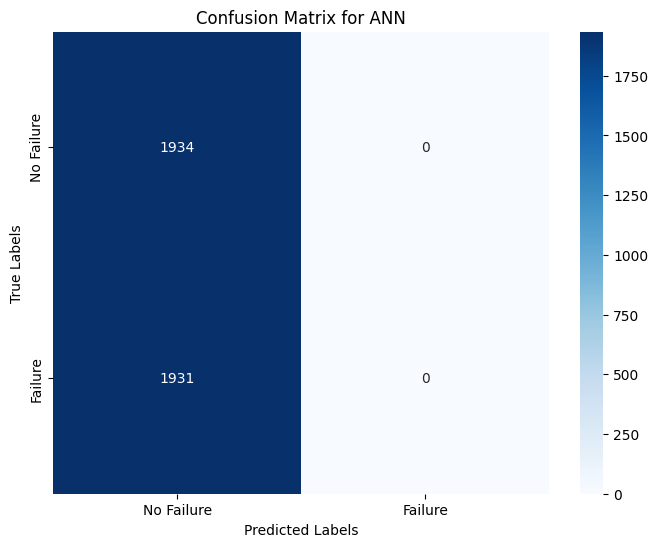

In [48]:
# Predict on the test set
y_pred_prob_Prmain_ann = best_model.predict(X_test)
y_pred_Prmain_ann = y_pred_prob_Prmain_ann.argmax(axis=1)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_Prmain_ann, target_names=['No Failure', 'Failure']))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_Prmain_ann)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ANN')
plt.show()

The most important feature is 'Torque [Nm]' with an importance of 23.34%


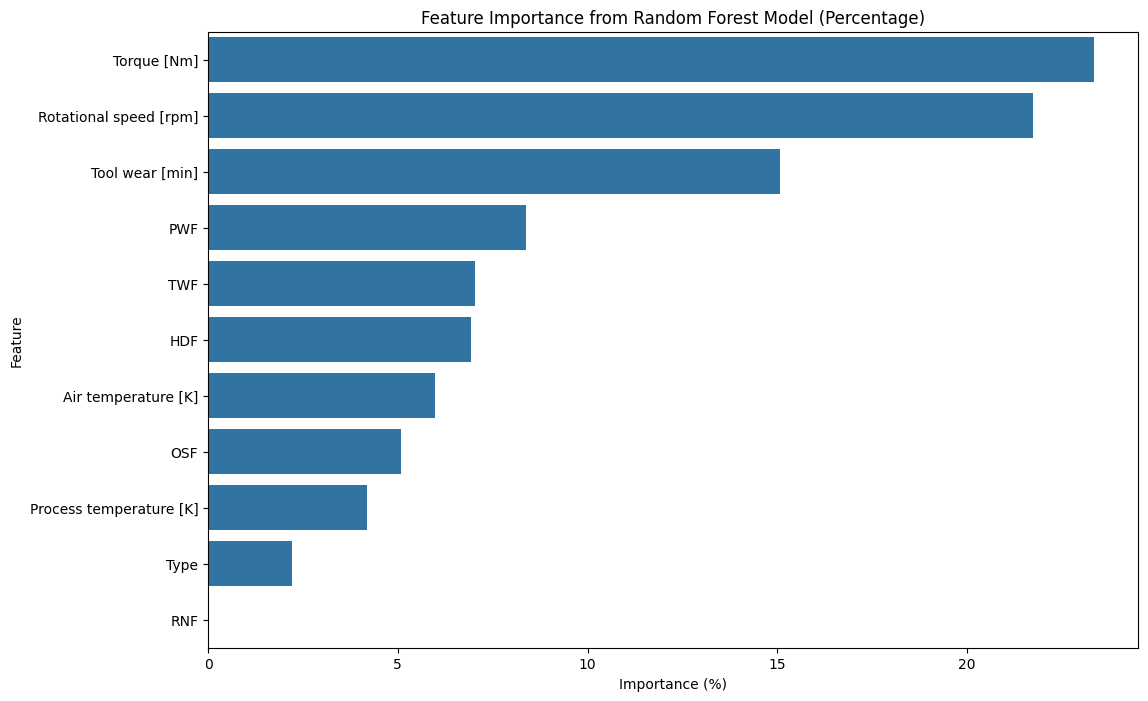

In [49]:
# Extract feature importances
fe_importances = Prmain_best_rf.feature_importances_

# Convert importances to percentages
importances_percentage = 100 * fe_importances / fe_importances.sum()

# Create a DataFrame with features and their importance percentages
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance (%)': importances_percentage})

# Sort the DataFrame by importance percentage in descending order
importance_df = importance_df.sort_values(by='Importance (%)', ascending=False)

# Print the most important feature
most_important_feature = importance_df.iloc[0]
print(f"The most important feature is '{most_important_feature['Feature']}' with an importance of {most_important_feature['Importance (%)']:.2f}%")

# Plot feature importances as percentage
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance (%)', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest Model (Percentage)')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.show()
